In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from pycaret.regression import *

In [24]:
def smape(a, b):
    s = pd.Series(2*abs(a-b)/(abs(a)+abs(b))).fillna(0)
    return 100*s.sum()/len(s)

In [25]:
proteins = pd.read_csv('../data/train_proteins.csv')
peptides = pd.read_csv('../data/train_peptides.csv')
clinical_data = pd.read_csv('../data/train_clinical_data.csv')
clinical_data.set_index('visit_id', inplace=True)


In [26]:
npx_features = pd.read_csv('../processed_data/proteins_features.csv').set_index('visit_id')


In [27]:
#npx_features = npx_features.fillna(0)


In [28]:
#sns.heatmap(npx_features.corr())


In [29]:
clinical_data.head()


,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
visit_id,,,,,,,
55_0,55,0,10.0,6.0,6,NaN,NaN
55_3,55,3,10.0,7.0,19,NaN,NaN
55_6,55,6,8.0,10.0,58,NaN,NaN
55_9,55,9,8.0,9.0,17,0.0,On
55_12,55,12,10.0,10.0,2,0.0,On


In [30]:
li = []
for idx, v in enumerate(clinical_data.index.values):
    parts = v.split('_')
    if parts[1] == '0':
        li.append('00000')
    else:
        li.append(clinical_data.index.values[idx-1])

def offset_updrs2(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_2']

def offset_updrs1(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_1']

def offset_updrs3(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_3']

def offset_updrs4(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_4']

clinical_data['offset'] = li

clinical_data['offset_updrs2_offset'] = clinical_data.apply(
    offset_updrs2, axis=1)
clinical_data['offset_updrs1_offset'] = clinical_data.apply(
    offset_updrs1, axis=1)
clinical_data['offset_updrs3_offset'] = clinical_data.apply(
    offset_updrs3, axis=1)
clinical_data['offset_updrs4_offset'] = clinical_data.apply(
    offset_updrs4, axis=1)





clinical_data.fillna(0, inplace=True)


In [31]:
clinical_data = clinical_data[[
    'updrs_1', 'updrs_2', 'offset_updrs2_offset', 'offset_updrs1_offset','offset_updrs3_offset','offset_updrs4_offset', 'updrs_3', 'updrs_4', 'visit_month']]


In [32]:
clinical_data

,updrs_1,updrs_2,offset_updrs2_offset,offset_updrs1_offset,offset_updrs3_offset,offset_updrs4_offset,updrs_3,updrs_4,visit_month
visit_id,,,,,,,,,
55_0,10.0,6.0,0.0,0.0,0,0.0,6,0.0,0
55_3,10.0,7.0,6.0,10.0,6,0.0,19,0.0,3
55_6,8.0,10.0,7.0,10.0,19,0.0,58,0.0,6
55_9,8.0,9.0,10.0,8.0,58,0.0,17,0.0,9
55_12,10.0,10.0,9.0,8.0,17,0.0,2,0.0,12
...,...,...,...,...,...,...,...,...,...
65043_48,7.0,6.0,10.0,9.0,4,0.0,51,0.0,48
65043_54,4.0,8.0,6.0,7.0,51,0.0,55,1.0,54
65043_60,6.0,6.0,8.0,4.0,55,1.0,0,1.0,60


In [33]:
#sns.pairplot(clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4','offset_updrs1_offset', 'offset_updrs2_offset', 'offset_updrs3_offset', 'offset_updrs4_offset','visit_month']])


In [34]:
patient_visits = []
for vi in clinical_data.index:
    if vi.startswith('40200') or vi.startswith('64674') or vi.startswith('23391'):
        patient_visits.append(vi)
clinical_data_holdout = clinical_data[clinical_data.index.isin(patient_visits)]
clinical_data_train = clinical_data[~clinical_data.index.isin(patient_visits)]
clinical_data_holdout

,updrs_1,updrs_2,offset_updrs2_offset,offset_updrs1_offset,offset_updrs3_offset,offset_updrs4_offset,updrs_3,updrs_4,visit_month
visit_id,,,,,,,,,
23391_0,0.0,3.0,0.0,0.0,0,0.0,6,0.0,0
23391_3,1.0,4.0,3.0,0.0,6,0.0,19,0.0,3
23391_6,2.0,4.0,4.0,1.0,19,0.0,58,0.0,6
23391_9,2.0,6.0,4.0,2.0,58,0.0,17,0.0,9
23391_12,4.0,5.0,6.0,2.0,17,0.0,2,0.0,12
23391_18,4.0,6.0,5.0,4.0,2,0.0,7,0.0,18
23391_24,4.0,7.0,6.0,4.0,7,0.0,16,0.0,24
23391_30,5.0,7.0,7.0,4.0,16,0.0,21,0.0,30
23391_36,6.0,7.0,7.0,5.0,21,0.0,9,0.0,36


# UPDRS 1 Predictions with just protein data

In [35]:
dataset = pd.merge(clinical_data_train[['updrs_1', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
b1 = create_model('et')
t1 = tune_model(b1, choose_better=True, optimize='SMAPE')
ensemble_u1 = ensemble_model(t1, choose_better= True, n_estimators=20)



,Description,Value
0,Session id,5552
1,Target,target
2,Target type,Regression
3,Original data shape,"(1049, 235)"
4,Transformed data shape,"(1049, 235)"
5,Transformed train set shape,"(734, 235)"
6,Transformed test set shape,"(315, 235)"
7,Numeric features,234
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,3.0366,15.4972,3.9366,0.4759,0.7240,0.8304,61.7191
1,2.7668,12.2002,3.4929,0.6466,0.6834,0.9005,61.5555
2,2.4024,8.9033,2.9838,0.6470,0.5561,0.7249,49.6029
3,1.8923,6.2366,2.4973,0.7999,0.5052,0.5226,48.0883
4,2.3848,9.4401,3.0725,0.6462,0.5221,0.6054,49.2344
5,2.1778,7.5872,2.7545,0.7127,0.5470,0.8347,52.3172
6,2.5108,13.1002,3.6194,0.4834,0.5781,0.6163,54.7246
7,2.8064,14.4647,3.8032,0.4124,0.5465,0.6209,46.4850
8,2.6056,12.0958,3.4779,0.5464,0.5835,0.6371,54.9712


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,2.9995,15.3375,3.9163,0.4813,0.7164,0.7969,60.6499
1,2.7657,12.3078,3.5082,0.6435,0.6763,0.8445,61.0038
2,2.3898,8.5112,2.9174,0.6626,0.5521,0.7122,48.9962
3,1.7563,5.1561,2.2707,0.8345,0.4830,0.5079,46.1088
4,2.3992,9.7115,3.1163,0.6361,0.5232,0.6299,50.2657
5,2.0853,7.3132,2.7043,0.7231,0.5411,0.8174,52.2960
6,2.5673,13.5490,3.6809,0.4657,0.5936,0.5956,55.0306
7,2.7637,14.6288,3.8248,0.4057,0.5269,0.5989,44.6561
8,2.5546,11.9923,3.4630,0.5503,0.5742,0.6059,55.0877


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,2.9673,14.6715,3.8303,0.5038,0.7153,0.7832,61.1608
1,2.7635,12.4214,3.5244,0.6402,0.6756,0.8254,61.2551
2,2.3758,8.4116,2.9003,0.6665,0.5580,0.7269,49.1607
3,1.8154,5.3161,2.3057,0.8294,0.5090,0.5673,46.8731
4,2.3415,9.2377,3.0394,0.6538,0.5335,0.6439,49.2184
5,2.0843,7.2341,2.6896,0.7261,0.5508,0.8320,51.9917
6,2.5883,13.4636,3.6693,0.4691,0.6184,0.6144,54.8737
7,2.8003,15.0364,3.8777,0.3892,0.5269,0.5966,45.4826
8,2.5815,12.2166,3.4952,0.5419,0.5918,0.6269,56.3362


In [36]:
predict_model(b1)
predict_model(t1)
predict_model(ensemble_u1)
finalize_model(ensemble_u1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.3606,11.0312,3.3213,0.6110,0.5419,0.5968,49.4795


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.3594,10.9759,3.3130,0.6129,0.5340,0.5859,49.4663


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,str,2.3823,11.1434,3.3382,0.6070,0.5478,0.6037,49.8835


Pipeline(memory=FastMemory(location=C:\Users\prith\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['feature_1', 'feature_2',
                                             'feature_3', 'feature_4',
                                             'feature_5', 'feature_6',
                                             'feature_7', 'feature_8',
                                             'feature_9', 'feature_10',
                                             'feature_11', 'feature_12',
                                             'feature_13', 'feature_14',
                                             'feature_15', 'feature_16',
                                             'feature_17', 'fea...
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 BaggingRegressor(estimator=ExtraTreesRegressor(max_depth=9,
                                                                min_impurity_decrease=0.005,
                                                                min_samples_leaf=3,
                                                                min_samples_split=7,
                                                                n_estimators=300,
                                                                n_jobs=-1,
                                                                random_state=5552),
                                  n_estimators=20, random_state=5552))])

# UPDRS 2 Predictions with just Protein Data

In [37]:
dataset = pd.merge(clinical_data_train[['updrs_2', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
b2 = create_model('et')
t2 = tune_model(b2, choose_better=True, optimize='SMAPE')
ensemble_u2 = ensemble_model(t2, choose_better= True, n_estimators=20)



,Description,Value
0,Session id,4334
1,Target,target
2,Target type,Regression
3,Original data shape,"(1049, 235)"
4,Transformed data shape,"(1049, 235)"
5,Transformed train set shape,"(734, 235)"
6,Transformed test set shape,"(315, 235)"
7,Numeric features,234
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,2.2397,8.8889,2.9814,0.6273,0.6723,0.7268,78.1771
1,2.0962,8.6067,2.9337,0.7720,0.4695,0.3808,66.3421
2,2.2224,9.0976,3.0162,0.7874,0.5537,0.4570,84.6483
3,2.0655,7.5465,2.7471,0.8306,0.5601,0.4296,79.7593
4,2.7078,15.9148,3.9893,0.6055,0.7008,0.5599,84.4883
5,1.7789,5.6953,2.3865,0.7392,0.4886,0.4518,83.1663
6,2.5542,15.1304,3.8898,0.5964,0.6969,0.7365,95.8371
7,2.0816,8.2883,2.8789,0.6853,0.6484,0.5426,83.4663
8,2.3829,11.6119,3.4076,0.7207,0.6299,0.8020,89.6545


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,2.1946,8.1830,2.8606,0.6569,0.6375,0.7349,78.0960
1,2.0600,8.3207,2.8846,0.7796,0.4680,0.3639,64.6082
2,2.2634,9.4258,3.0701,0.7797,0.5707,0.4367,84.0549
3,1.9455,6.9810,2.6422,0.8433,0.5632,0.3888,77.8383
4,2.6749,15.4380,3.9291,0.6173,0.7066,0.5356,84.8260
5,1.7233,5.2959,2.3013,0.7575,0.4763,0.4205,80.7923
6,2.5632,15.1857,3.8969,0.5949,0.6973,0.7092,95.6750
7,2.0620,8.3977,2.8979,0.6811,0.6457,0.5402,83.1349
8,2.3873,11.3990,3.3762,0.7259,0.6107,0.7669,90.5934


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,2.1836,8.0710,2.8409,0.6616,0.6405,0.7216,78.1517
1,2.1407,9.3005,3.0497,0.7536,0.4895,0.3528,64.4694
2,2.2852,9.5694,3.0934,0.7764,0.5897,0.4398,83.8340
3,1.9270,6.5452,2.5584,0.8531,0.5728,0.3915,77.8227
4,2.6758,15.3154,3.9135,0.6203,0.7038,0.5439,84.9832
5,1.8105,5.6413,2.3751,0.7417,0.5061,0.4084,79.3291
6,2.5042,15.1195,3.8884,0.5967,0.6808,0.6165,93.0609
7,2.0813,7.9246,2.8151,0.6991,0.6558,0.5350,82.7454
8,2.3693,10.9544,3.3097,0.7365,0.6224,0.7300,87.8184


In [38]:
predict_model(b2)
predict_model(t2)
predict_model(ensemble_u2)
finalize_model(ensemble_u2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.2436,10.0278,3.1667,0.7074,0.6110,0.5433,83.4471


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,2.2440,9.9093,3.1479,0.7108,0.6016,0.5137,82.3742


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,str,2.2840,9.8054,3.1314,0.7139,0.6226,0.5241,82.0192


Pipeline(memory=FastMemory(location=C:\Users\prith\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['feature_1', 'feature_2',
                                             'feature_3', 'feature_4',
                                             'feature_5', 'feature_6',
                                             'feature_7', 'feature_8',
                                             'feature_9', 'feature_10',
                                             'feature_11', 'feature_12',
                                             'feature_13', 'feature_14',
                                             'feature_15', 'feature_16',
                                             'feature_17', 'fea...
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 BaggingRegressor(estimator=ExtraTreesRegressor(max_depth=8,
                                                                min_impurity_decrease=0.05,
                                                                min_samples_leaf=2,
                                                                min_samples_split=5,
                                                                n_estimators=90,
                                                                n_jobs=-1,
                                                                random_state=4334),
                                  n_estimators=20, random_state=4334))])

# UPDRS 3 Predictions with Proteins Data

In [39]:
dataset = pd.merge(clinical_data_train[['updrs_3', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
b3 = create_model('et')
t3 = tune_model(b3, choose_better=True, optimize='SMAPE')
ensemble_u3 = ensemble_model(t3, choose_better= True, n_estimators=20)



,Description,Value
0,Session id,2960
1,Target,target
2,Target type,Regression
3,Original data shape,"(1049, 235)"
4,Transformed data shape,"(1049, 235)"
5,Transformed train set shape,"(734, 235)"
6,Transformed test set shape,"(315, 235)"
7,Numeric features,234
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,0.9282,9.4927,3.0810,0.9744,0.3510,0.0532,14.7342
1,0.8582,5.4947,2.3441,0.9887,0.4085,0.0459,12.0658
2,1.1991,31.6151,5.6227,0.9356,0.3578,0.0701,14.5998
3,0.7565,5.7936,2.4070,0.9867,0.3425,0.0535,17.2449
4,0.5085,7.8437,2.8007,0.9794,0.3807,0.0178,9.7474
5,1.1178,32.4300,5.6947,0.8944,0.5448,0.0606,25.9343
6,1.8526,76.2796,8.7338,0.7927,0.4751,0.0939,17.7792
7,0.6725,3.4830,1.8663,0.9910,0.4097,0.0526,20.6025
8,0.8247,23.7739,4.8759,0.9258,0.4591,0.0539,20.2562


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,1.9835,37.3074,6.1080,0.8993,0.4971,0.1227,25.6196
1,1.6799,9.2313,3.0383,0.9811,0.3603,0.1635,30.3601
2,1.6636,10.0072,3.1634,0.9796,0.4438,0.1636,30.5295
3,1.7148,25.1375,5.0137,0.9423,0.5371,0.0828,30.8799
4,1.8785,37.3365,6.1104,0.9021,0.5199,0.1475,23.6131
5,1.5378,27.9956,5.2911,0.9088,0.5500,0.1912,44.6488
6,2.8541,77.6457,8.8117,0.7890,0.4674,0.2174,39.7072
7,1.6205,31.7600,5.6356,0.9178,0.5836,0.1075,26.9266
8,1.6466,34.4904,5.8728,0.8923,0.5512,0.1151,30.3565


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,1.3797,12.4709,3.5314,0.9664,0.4329,0.1129,24.8797
1,1.3006,5.4857,2.3422,0.9888,0.3691,0.0951,26.8849
2,1.4588,24.3709,4.9367,0.9503,0.2547,0.1177,29.0854
3,1.3308,12.0930,3.4775,0.9723,0.4265,0.1160,32.4117
4,1.0221,10.8326,3.2913,0.9716,0.4068,0.0752,20.0254
5,1.3527,32.4033,5.6924,0.8945,0.5297,0.1114,40.8490
6,2.1657,76.8463,8.7662,0.7911,0.4786,0.1403,35.2521
7,0.9767,6.9319,2.6328,0.9820,0.4571,0.0941,26.4456
8,1.0366,14.6437,3.8267,0.9543,0.4431,0.1200,29.9314


In [40]:
predict_model(b3)
predict_model(t3)
predict_model(ensemble_u3)
finalize_model(ensemble_u3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.8076,11.1385,3.3374,0.9763,0.4192,0.0639,18.3835


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.8076,11.1385,3.3374,0.9763,0.4192,0.0639,18.3835


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,str,1.2168,16.1963,4.0245,0.9655,0.4454,0.0878,28.3934


Pipeline(memory=FastMemory(location=C:\Users\prith\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['feature_1', 'feature_2',
                                             'feature_3', 'feature_4',
                                             'feature_5', 'feature_6',
                                             'feature_7', 'feature_8',
                                             'feature_9', 'feature_10',
                                             'feature_11', 'feature_12',
                                             'feature_13', 'feature_14',
                                             'feature_15', 'feature_16',
                                             'feature_17', 'fea...
                                             'feature_25', 'feature_26',
                                             'feature_27', 'feature_28',
                                             'feature_29', 'feature_30', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 BaggingRegressor(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                random_state=2960),
                                  n_estimators=20, random_state=2960))])

# UPDRS 4 Predictions with Proteins Data

In [41]:
dataset = pd.merge(clinical_data_train[['updrs_4', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[6:]].values
X_noscale = dataset[dataset.columns[1:6]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))

s = setup(data=final_X, target=Y)
add_metric('SMAPE', 'SMAPE', smape, greater_is_better = False)
b4 = create_model('et')
t4 = tune_model(b4, choose_better=True, optimize='SMAPE')
ensemble_u4 = ensemble_model(t4, choose_better= True, n_estimators=20)



,Description,Value
0,Session id,1669
1,Target,target
2,Target type,Regression
3,Original data shape,"(1049, 235)"
4,Transformed data shape,"(1049, 235)"
5,Transformed train set shape,"(734, 235)"
6,Transformed test set shape,"(315, 235)"
7,Numeric features,234
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,1.0515,3.5486,1.8838,0.4696,0.6433,0.6038,150.1079
1,0.8691,3.8502,1.9622,0.4196,0.4968,0.6140,173.6479
2,0.9989,2.5032,1.5821,0.6122,0.5879,0.5413,159.9287
3,0.9253,3.4532,1.8583,0.6310,0.5009,0.8809,160.0893
4,0.8403,2.0068,1.4166,0.6600,0.5008,0.6323,162.5601
5,1.2659,4.6430,2.1548,0.1352,0.7124,0.6524,152.7401
6,1.0527,3.5775,1.8914,0.1877,0.6235,1.0082,172.1773
7,1.0388,4.0467,2.0116,0.6305,0.5641,0.4091,164.6338
8,1.4427,6.5477,2.5589,0.0245,0.7374,0.6310,155.2879


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,1.1081,7.9189,2.8141,-0.1835,0.8155,1.0000,45.9459
1,0.9595,7.5541,2.7485,-0.1388,0.7556,1.0000,35.1351
2,1.2432,8.0000,2.8284,-0.2395,0.8704,1.0000,54.0541
3,1.2162,10.8378,3.2921,-0.1581,0.8434,1.0000,35.1351
4,0.9589,6.8219,2.6119,-0.1558,0.7579,1.0000,41.0959
5,0.9726,6.3151,2.5130,-0.1762,0.7698,1.0000,41.0959
6,0.9178,5.2466,2.2905,-0.1913,0.7568,1.0000,38.3562
7,1.2466,12.5068,3.5365,-0.1419,0.8452,1.0000,38.3562
8,1.4384,8.7808,2.9632,-0.3082,0.9418,1.0000,60.2740


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,1.1051,7.8700,2.8053,-0.1762,0.8074,0.9970,56.4862
1,0.9575,7.5264,2.7434,-0.1346,0.7503,0.9975,37.6642
2,1.2413,7.9641,2.8221,-0.2339,0.8647,0.9984,59.2878
3,1.2150,10.8178,3.2890,-0.1559,0.8403,0.9983,40.4244
4,0.9563,6.7836,2.6045,-0.1493,0.7511,0.9968,49.0531
5,0.9704,6.2758,2.5051,-0.1689,0.7615,0.9947,57.1053
6,0.9134,5.2078,2.2821,-0.1825,0.7478,0.9906,43.1418
7,1.2452,12.4772,3.5323,-0.1392,0.8411,0.9988,43.7411
8,1.4370,8.7627,2.9602,-0.3055,0.9384,0.9987,73.8115


In [42]:
predict_model(b4)
predict_model(t4)
predict_model(ensemble_u4)
finalize_model(ensemble_u4)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.9134,2.4151,1.5541,0.4124,0.5514,0.7075,165.0971


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,Extra Trees Regressor,0.8984,4.9175,2.2175,-0.1964,0.7471,1.0000,42.5397


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
0,str,0.8977,4.9096,2.2158,-0.1945,0.7454,0.9990,45.6256


Pipeline(memory=FastMemory(location=C:\Users\prith\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['feature_1', 'feature_2',
                                             'feature_3', 'feature_4',
                                             'feature_5', 'feature_6',
                                             'feature_7', 'feature_8',
                                             'feature_9', 'feature_10',
                                             'feature_11', 'feature_12',
                                             'feature_13', 'feature_14',
                                             'feature_15', 'feature_16',
                                             'feature_17', 'fea...
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 BaggingRegressor(estimator=ExtraTreesRegressor(bootstrap=True,
                                                                criterion='absolute_error',
                                                                max_depth=6,
                                                                min_impurity_decrease=0.5,
                                                                min_samples_leaf=6,
                                                                n_estimators=70,
                                                                n_jobs=-1,
                                                                random_state=1669),
                                  n_estimators=20, random_state=1669))])

In [43]:
ensemble_u1

BaggingRegressor(estimator=ExtraTreesRegressor(max_depth=9,
                                               min_impurity_decrease=0.005,
                                               min_samples_leaf=3,
                                               min_samples_split=7,
                                               n_estimators=300, n_jobs=-1,
                                               random_state=5552),
                 n_estimators=20, random_state=5552)

In [94]:
updrs1_test = pd.merge(clinical_data_holdout[['updrs_1', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
Y_test = updrs1_test[updrs1_test.columns[0]].values
X_test = updrs1_test[updrs1_test.columns[6:]].values
X_noscale_test = updrs1_test[updrs1_test.columns[1:6]].values
X_scaled_test = StandardScaler().fit(X).transform(X_test)
final_X_test = np.hstack((X_noscale, X_scaled))

y_predict = predict_model(ensemble_u1, data=pd.DataFrame(final_X_test, columns=[f'feature_{i+1}' for i in range(final_X_test.shape[1])]))['prediction_label']
updrs1_test.reset_index(inplace=True)
updrs1_test['prediction'] = y_predict
plot1 = updrs1_test[['visit_id', 'updrs_1', 'prediction']]
plot1

,visit_id,updrs_1,prediction
0,23391_0,0.0,4.197856
1,23391_6,2.0,8.937212
2,23391_12,4.0,8.131991
3,23391_24,4.0,15.540882
4,23391_36,6.0,6.467240
5,23391_48,5.0,6.278692
6,23391_60,4.0,5.015476
7,23391_72,8.0,2.816042
8,23391_84,11.0,7.350113
9,40200_0,0.0,18.251985


In [80]:
updrs2_test = pd.merge(clinical_data_holdout[['updrs_2', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
Y_test = updrs2_test[updrs2_test.columns[0]].values
X_test = updrs2_test[updrs2_test.columns[6:]].values
X_noscale_test = updrs2_test[updrs2_test.columns[1:6]].values
X_scaled_test = StandardScaler().fit(X).transform(X_test)
final_X_test = np.hstack((X_noscale, X_scaled))

y_predict = predict_model(ensemble_u2, data=pd.DataFrame(final_X_test, columns=[f'feature_{i+1}' for i in range(final_X_test.shape[1])]))['prediction_label']
updrs2_test.reset_index(inplace=True)
updrs2_test['prediction'] = y_predict
plot2 = updrs2_test[['visit_id', 'updrs_2', 'prediction']]
plot2

,visit_id,updrs_2,prediction
0,23391_0,3.0,3.386836
1,23391_6,4.0,8.389067
2,23391_12,5.0,9.330175
3,23391_24,7.0,16.377445
4,23391_36,7.0,3.007615
5,23391_48,6.0,2.928668
6,23391_60,5.0,5.134220
7,23391_72,6.0,4.066000
8,23391_84,15.0,3.682490
9,40200_0,4.0,12.344390


In [82]:
updrs3_test = pd.merge(clinical_data_holdout[['updrs_3', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
Y_test = updrs3_test[updrs3_test.columns[0]].values
X_test = updrs3_test[updrs3_test.columns[6:]].values
X_noscale_test = updrs3_test[updrs3_test.columns[1:6]].values
X_scaled_test = StandardScaler().fit(X).transform(X_test)
final_X_test = np.hstack((X_noscale, X_scaled))

y_predict = predict_model(ensemble_u3, data=pd.DataFrame(final_X_test, columns=[f'feature_{i+1}' for i in range(final_X_test.shape[1])]))['prediction_label']
updrs3_test.reset_index(inplace=True)
updrs3_test['prediction'] = y_predict
plot3 = updrs3_test[['visit_id', 'updrs_3', 'prediction']]
plot3

,visit_id,updrs_3,prediction
0,23391_0,6,6.0015
1,23391_6,58,57.3415
2,23391_12,2,2.1930
3,23391_24,16,9.0655
4,23391_36,9,57.6105
5,23391_48,51,2.0755
6,23391_60,0,16.0370
7,23391_72,58,50.3930
8,23391_84,0,6.0000
9,40200_0,6,15.9920


In [83]:
updrs4_test = pd.merge(clinical_data_holdout[['updrs_4', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset','visit_month']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
Y_test = updrs4_test[updrs4_test.columns[0]].values
X_test = updrs4_test[updrs4_test.columns[6:]].values
X_noscale_test = updrs4_test[updrs4_test.columns[1:6]].values
X_scaled_test = StandardScaler().fit(X).transform(X_test)
final_X_test = np.hstack((X_noscale, X_scaled))

y_predict = predict_model(ensemble_u4, data=pd.DataFrame(final_X_test, columns=[f'feature_{i+1}' for i in range(final_X_test.shape[1])]))['prediction_label']
updrs4_test.reset_index(inplace=True)
updrs4_test['prediction'] = y_predict
plot4 = updrs4_test[['visit_id', 'updrs_4', 'prediction']]
plot4

,visit_id,updrs_4,prediction
0,23391_0,0.0,0.000000
1,23391_6,0.0,0.000000
2,23391_12,0.0,0.000000
3,23391_24,0.0,0.000000
4,23391_36,0.0,0.000000
5,23391_48,0.0,0.000000
6,23391_60,0.0,0.000000
7,23391_72,1.0,0.000000
8,23391_84,0.0,0.000000
9,40200_0,0.0,0.009286


In [113]:
plot1['patient'] = plot1['visit_id'].apply(lambda x: x.split('_')[0])
plot2['patient'] = plot2['visit_id'].apply(lambda x: x.split('_')[0])
plot3['patient'] = plot3['visit_id'].apply(lambda x: x.split('_')[0])
plot4['patient'] = plot4['visit_id'].apply(lambda x: x.split('_')[0])
plot1['month'] = plot1['visit_id'].apply(lambda x: int(x.split('_')[1]))
plot2['month'] = plot2['visit_id'].apply(lambda x: int(x.split('_')[1]))
plot3['month'] = plot3['visit_id'].apply(lambda x: int(x.split('_')[1]))
plot4['month'] = plot4['visit_id'].apply(lambda x: int(x.split('_')[1]))

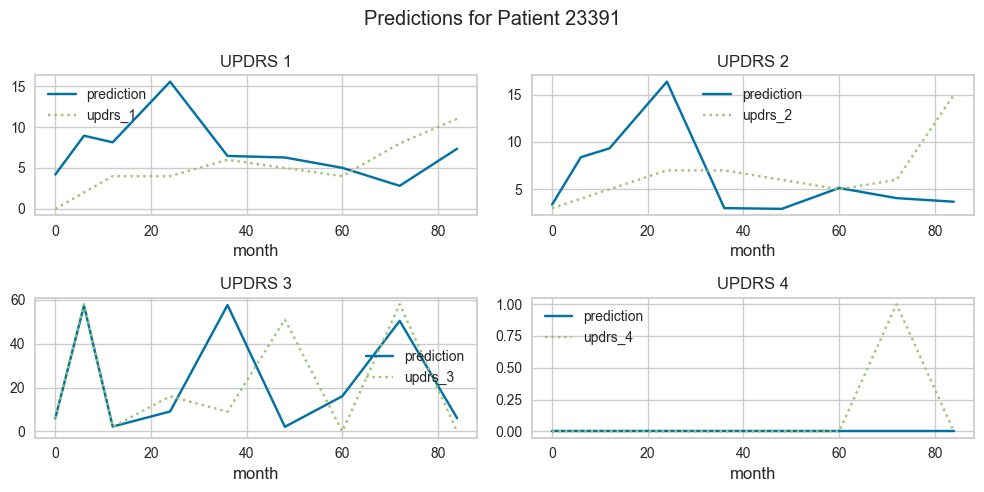

In [139]:
import matplotlib.pyplot as plt

pid='23391'
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,5))
plot1[plot1['patient']==pid].plot.line(x='month',y='prediction',ax=ax1)
plot1[plot1['patient']==pid].plot.line(x='month',y='updrs_1',ax=ax1,ls=":")
plot2[plot2['patient']==pid].plot.line(x='month',y='prediction',ax=ax2)
plot2[plot2['patient']==pid].plot.line(x='month',y='updrs_2',ax=ax2, ls=':')
plot3[plot3['patient']==pid].plot.line(x='month',y='prediction',ax=ax3)
plot3[plot3['patient']==pid].plot.line(x='month',y='updrs_3',ax=ax3, ls=':')
plot4[plot4['patient']==pid].plot.line(x='month',y='prediction',ax=ax4)
plot4[plot4['patient']==pid].plot.line(x='month',y='updrs_4',ax=ax4, ls=':')
plt.suptitle(f'Predictions for Patient {pid}')
ax1.set_title('UPDRS 1')
ax2.set_title('UPDRS 2')
ax3.set_title('UPDRS 3')
ax4.set_title('UPDRS 4')
fig.tight_layout()

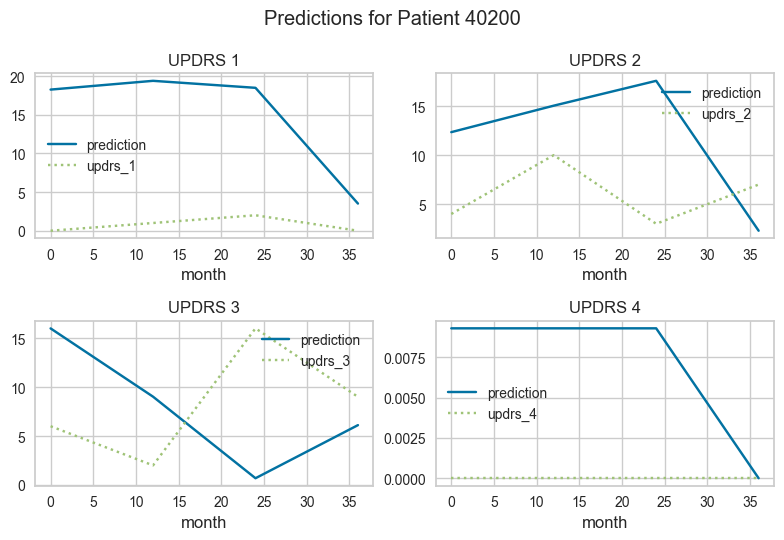

In [140]:
import matplotlib.pyplot as plt

pid='40200'
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
plot1[plot1['patient']==pid].plot.line(x='month',y='prediction',ax=ax1)
plot1[plot1['patient']==pid].plot.line(x='month',y='updrs_1',ax=ax1,ls=":")
plot2[plot2['patient']==pid].plot.line(x='month',y='prediction',ax=ax2)
plot2[plot2['patient']==pid].plot.line(x='month',y='updrs_2',ax=ax2, ls=':')
plot3[plot3['patient']==pid].plot.line(x='month',y='prediction',ax=ax3)
plot3[plot3['patient']==pid].plot.line(x='month',y='updrs_3',ax=ax3, ls=':')
plot4[plot4['patient']==pid].plot.line(x='month',y='prediction',ax=ax4)
plot4[plot4['patient']==pid].plot.line(x='month',y='updrs_4',ax=ax4, ls=':')
plt.suptitle(f'Predictions for Patient {pid}')
ax1.set_title('UPDRS 1')
ax2.set_title('UPDRS 2')
ax3.set_title('UPDRS 3')
ax4.set_title('UPDRS 4')
fig.tight_layout()


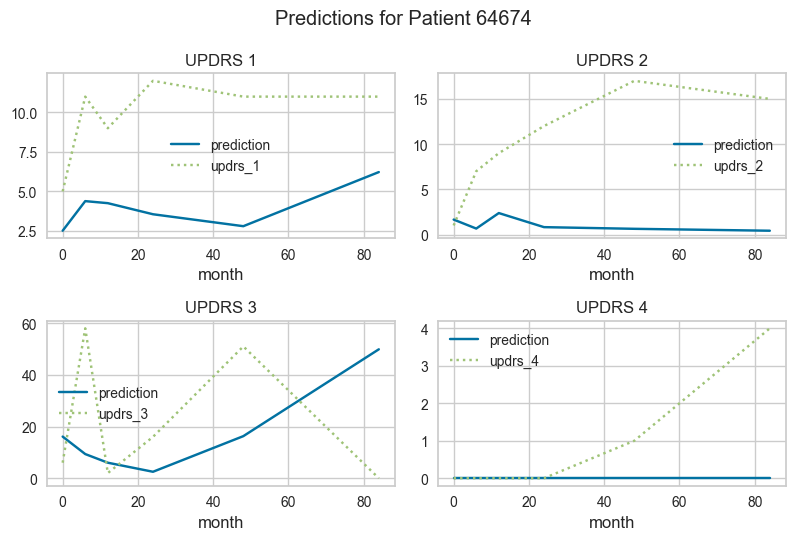

In [141]:
import matplotlib.pyplot as plt

pid='64674'
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
plot1[plot1['patient']==pid].plot.line(x='month',y='prediction',ax=ax1)
plot1[plot1['patient']==pid].plot.line(x='month',y='updrs_1',ax=ax1,ls=":")
plot2[plot2['patient']==pid].plot.line(x='month',y='prediction',ax=ax2)
plot2[plot2['patient']==pid].plot.line(x='month',y='updrs_2',ax=ax2, ls=':')
plot3[plot3['patient']==pid].plot.line(x='month',y='prediction',ax=ax3)
plot3[plot3['patient']==pid].plot.line(x='month',y='updrs_3',ax=ax3, ls=':')
plot4[plot4['patient']==pid].plot.line(x='month',y='prediction',ax=ax4)
plot4[plot4['patient']==pid].plot.line(x='month',y='updrs_4',ax=ax4, ls=':')
plt.suptitle(f'Predictions for Patient {pid}')
ax1.set_title('UPDRS 1')
ax2.set_title('UPDRS 2')
ax3.set_title('UPDRS 3')
ax4.set_title('UPDRS 4')
fig.tight_layout()